In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [9]:
from datasets import load_dataset

ds = load_dataset("rixmape/utkface")

README.md:   0%|          | 0.00/820 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23705 [00:00<?, ? examples/s]

In [13]:
from PIL import Image
images = []
ages = []
genders = []

for item in ds['train']:
    img = item['image']

    # Convert to PIL.Image if it's not already
    if not isinstance(img, Image.Image):
        img = Image.fromarray(np.array(img))

    img_resized = img.resize((64, 64))
    img_array = np.array(img_resized) / 255.0  # Normalize to [0,1]

    if img_array.shape == (64, 64, 3):  # Ensure RGB
        images.append(img_array)
        ages.append(item['age'])
        genders.append(item['gender'])

images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32) / 100.0
genders = to_categorical(genders, 2)

In [15]:
X_train, X_test, age_train, age_test, gender_train, gender_test = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input_layer = Input(shape=(64, 64, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

# Age output (regression)
age_output = Dense(1, activation='linear', name='age_output')(x)

# Gender output (classification)
gender_output = Dense(2, activation='softmax', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output])

In [17]:
model.compile(
    loss={'age_output': 'mean_squared_error', 'gender_output': 'categorical_crossentropy'},
    optimizer=Adam(learning_rate=0.001),
    metrics={'age_output': 'mae', 'gender_output': 'accuracy'}
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 6, 6, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4608)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │      4,609 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 2)         │      9,218 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 107,075 (418.26 KB)

 Trainable params: 107,075 (418.26 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train,
    {'age_output': age_train, 'gender_output': gender_train},
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 113s 457ms/step - age_output_loss: 0.0092 - age_output_mae: 0.0706 - gender_output_accuracy: 0.6824 - gender_output_loss: 0.5781 - loss: 0.5873 - val_age_output_loss: 0.0018 - val_age_output_mae: 0.0341 - val_gender_output_accuracy: 0.8381 - val_gender_output_loss: 0.3666 - val_loss: 0.3689
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 441ms/step - age_output_loss: 0.0056 - age_output_mae: 0.0575 - gender_output_accuracy: 0.8367 - gender_output_loss: 0.3755 - loss: 0.3810 - val_age_output_loss: 0.0070 - val_age_output_mae: 0.0798 - val_gender_output_accuracy: 0.8558 - val_gender_output_loss: 0.3269 - val_loss: 0.3349
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 427ms/step - age_output_loss: 0.0021 - age_output_mae: 0.0349 - gender_output_accuracy: 0.8511 - gender_output_loss: 0.3396 - loss: 0.3417 - val_age_output_loss: 3.3758e-04 - val_age_output_mae: 0.0144 - val_gender_output_accuracy: 0.8663 - val_gender_output_loss: 0.3180 - val_loss: 0.3189


In [19]:
results = model.evaluate(X_test, {'age_output': age_test, 'gender_output': gender_test})
print(f"Test Loss: {results[0]}")
print(f"Age MAE: {results[3]}")
print(f"Gender Accuracy: {results[4]}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - age_output_loss: 3.1017e-04 - age_output_mae: 0.0138 - gender_output_accuracy: 0.8969 - gender_output_loss: 0.2564 - loss: 0.2567
Test Loss: 0.2713508605957031
Age MAE: 0.013831554912030697
Gender Accuracy: 0.8882092237472534


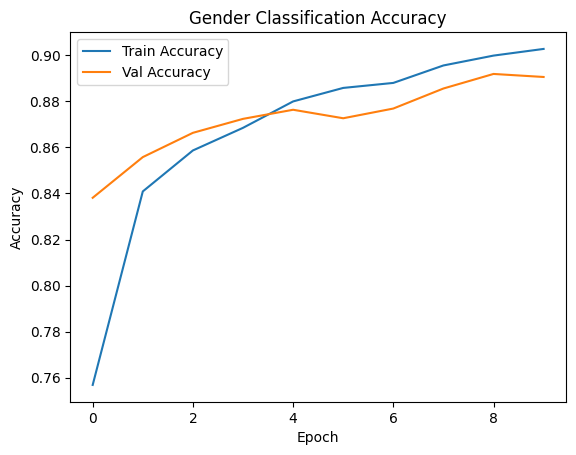

In [20]:
plt.plot(history.history['gender_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
